# Import the libraries

In [1]:
import math
import numpy as np
import pandas as pd
import pytse_client as tse

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential 
from keras.layers import Dense, LSTM, GRU

import datetime
from datetime import timedelta

from os import mkdir, path

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


# Acquire Data

## Enter Ticker Name

In [2]:
ticker_name = input("Enter ticker name: ")
ticker_name

'آریا'

## Download Ticker Data

In [3]:
tickers = tse.download([ticker_name], write_to_csv=True)

## Read Ticker Data As pandas DataFrame

In [4]:
filepath = './tickers_data/'+ ticker_name + '.csv'

df = pd.read_csv(filepath, parse_dates=True, index_col='date')
df.head()

,open,high,low,adjClose,value,volume,count,close
date,,,,,,,,
2020-05-27,65119.0,65119.0,65119.0,65119.0,11939791877932,183353428,3350038,65119.0
2020-05-30,68374.0,68374.0,68374.0,65254.0,4342022496,63504,1334,68374.0
2020-05-31,68516.0,68516.0,68516.0,65516.0,8448982024,123314,2519,68516.0
2020-06-01,68791.0,68791.0,68791.0,68791.0,114630570760,1666360,3406,68791.0
2020-06-02,72230.0,72230.0,72230.0,72230.0,116104813360,1607432,2209,72230.0


In [5]:
df.shape

(200, 8)

# Preprocessing

## Visualize Close Price 

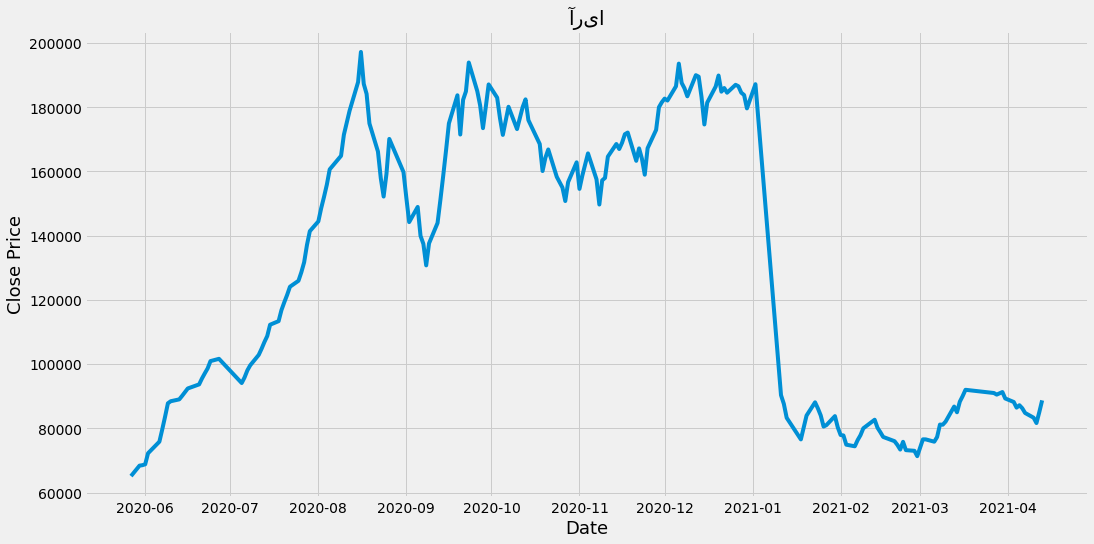

In [6]:
plt.figure(figsize=(16,8))
plt.title(ticker_name)
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.show()

## Scale Data

In [7]:
data = df.filter(['close'])
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.values)

## Train-Test Split Size

In [8]:
train_size_percentage = 0.8

training_data_len = math.ceil((train_size_percentage * scaled_data.shape[0]))
training_data_len

160

## Create 2-day TimeFrame Datasets

Each row in new datasets contains two sequential rows from datasets above

In [9]:
lookback = 7

In [10]:
train_data = scaled_data[0:training_data_len, :]

X_train = []
y_train = []

for i in range(lookback, len(train_data)):
  X_train.append(train_data[i-lookback:i, 0])
  y_train.append(train_data[i, 0])

In [11]:
test_data = scaled_data[training_data_len - lookback:]

X_test = []
y_test = []

for i in range(lookback, len(test_data)):
  X_test.append(test_data[i-lookback:i, 0])
  y_test.append(test_data[i, 0])

## Convert TimeFrames To Numpy Arrays

In [12]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [14]:
X_train.shape

(153, 7)

In [15]:
y_train.shape

(153,)

In [16]:
X_test.shape

(40, 7)

In [17]:
y_test.shape

(40,)

## Reshape Data

In [18]:
X_train = np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(153, 7, 1)

In [19]:
X_test = np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(40, 7, 1)

# Training and Evaluation

## GRU Training

### Build GRU Model

In [20]:
modelGRU = Sequential()
modelGRU.add(GRU(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
modelGRU.add(GRU(100, return_sequences=False))
modelGRU.add(Dense(100, activation='tanh'))
modelGRU.add(Dense(50, activation='sigmoid'))
modelGRU.add(Dense(1))

### Compile GRU Model

In [21]:
modelGRU.compile(optimizer='adam', loss='mean_squared_error')

### Train GRU Model

In [22]:
modelGRU.fit(X_train, y_train, epochs=50, batch_size=1, validation_split=0.2)

Epoch 1/50
122/122 [==============================] - 2s 14ms/step - loss: 0.0401 - val_loss: 0.0439
Epoch 2/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0057 - val_loss: 0.0482
Epoch 3/50
122/122 [==============================] - 1s 6ms/step - loss: 0.0061 - val_loss: 0.0317
Epoch 4/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0058 - val_loss: 0.0242
Epoch 5/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0058 - val_loss: 0.0244
Epoch 6/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0030 - val_loss: 0.0211
Epoch 7/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0040 - val_loss: 0.0243
Epoch 8/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0186
Epoch 9/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0033 - val_loss: 0.0174
Epoch 10/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.019

## LSTM Training

### Build LSTM Model

In [23]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
modelLSTM.add(LSTM(100, return_sequences=False))
modelLSTM.add(Dense(100, activation='tanh'))
modelLSTM.add(Dense(50, activation='sigmoid'))
modelLSTM.add(Dense(1))

### Compile LSTM Model

In [24]:
modelLSTM.compile(optimizer='adam', loss='mean_squared_error')

### Train LSTM Model

In [25]:
modelLSTM.fit(X_train, y_train, epochs=50, batch_size=1, validation_split=0.2)

Epoch 1/50
122/122 [==============================] - 2s 14ms/step - loss: 0.0350 - val_loss: 0.0616
Epoch 2/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0106 - val_loss: 0.1126
Epoch 3/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0132 - val_loss: 0.0847
Epoch 4/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0096 - val_loss: 0.0656
Epoch 5/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0082 - val_loss: 0.0653
Epoch 6/50
122/122 [==============================] - 1s 4ms/step - loss: 0.0076 - val_loss: 0.0471
Epoch 7/50
122/122 [==============================] - 1s 4ms/step - loss: 0.0067 - val_loss: 0.0482
Epoch 8/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0060 - val_loss: 0.0353
Epoch 9/50
122/122 [==============================] - 1s 4ms/step - loss: 0.0049 - val_loss: 0.0269
Epoch 10/50
122/122 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.029

## GRU Evaluation

In [26]:
predictionsGRU = modelGRU.predict(X_test)
predictionsGRU = scaler.inverse_transform(predictionsGRU)

## LSTM Evaluation

In [27]:
predictionsLSTM = modelLSTM.predict(X_test)
predictionsLSTM = scaler.inverse_transform(predictionsLSTM)

## Test Data Preparation

In [28]:
train = data[:training_data_len]
test = data[training_data_len:]
test['GRU Predictions'] = predictionsGRU
test['LSTM Predictions'] = predictionsLSTM

<ipython-input-28-b7732a8de6fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['GRU Predictions'] = predictionsGRU
<ipython-input-28-b7732a8de6fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = predictionsLSTM


## GRU RMSE

In [29]:
rmse = np.sqrt(mean_squared_error(test['close'],predictionsGRU))
rmse

5666.843271444153

## LSTM RMSE

In [30]:
rmse = np.sqrt(mean_squared_error(test['close'],predictionsLSTM))
rmse

2357.409647595089

## Visualize Test Results

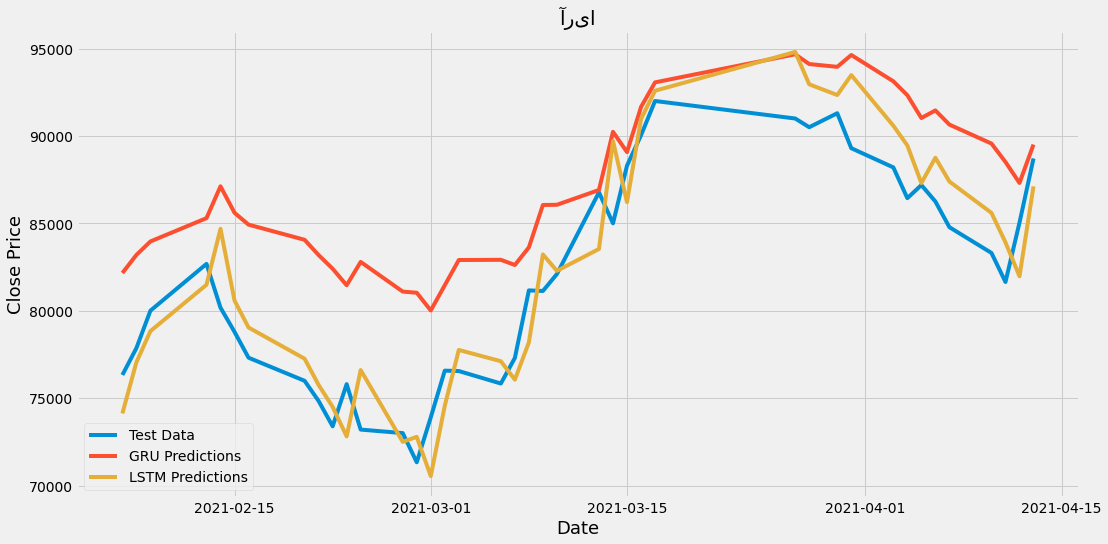

In [31]:
plt.figure(figsize=(16,8))
plt.title(ticker_name)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
#plt.plot(train['close'])
plt.plot(test[['close', 'GRU Predictions', 'LSTM Predictions']])
plt.legend(['Test Data', 'GRU Predictions', 'LSTM Predictions'], loc='lower left')
plt.show()

# Prediction (30-Day Forecast)

## Number of Future Predictions (Days)

In [32]:
X_FUTURE = 360

## GRU Forecasting

In [33]:
predictionsGRU = np.array([])
last = X_test[-1]
for i in range(X_FUTURE):
  curr_prediction_GRU = modelGRU.predict(np.array([last]))
  last = np.concatenate([last[1:], curr_prediction_GRU])
  predictionsGRU = np.concatenate([predictionsGRU, curr_prediction_GRU[0]])
predictionsGRU = scaler.inverse_transform([predictionsGRU])[0]

In [34]:
dicts = []
curr_date = data.index[-1]
for i in range(X_FUTURE):
  curr_date = curr_date + timedelta(days=1)
  dicts.append({'Predictions':predictionsGRU[i], "Date": curr_date})

new_data_GRU = pd.DataFrame(dicts).set_index("Date")

## LSTM Forecasting

In [35]:
predictionsLSTM = np.array([])
last = X_test[-1]
for i in range(X_FUTURE):
  curr_prediction_LSTM = modelLSTM.predict(np.array([last]))
  last = np.concatenate([last[1:], curr_prediction_LSTM])
  predictionsLSTM = np.concatenate([predictionsLSTM, curr_prediction_LSTM[0]])
predictionsLSTM = scaler.inverse_transform([predictionsLSTM])[0]

In [36]:
dicts = []
curr_date = data.index[-1]
for i in range(X_FUTURE):
  curr_date = curr_date + timedelta(days=1)
  dicts.append({'Predictions':predictionsLSTM[i], "Date": curr_date})

new_data_LSTM = pd.DataFrame(dicts).set_index("Date")

## Visualize Future Prediction 

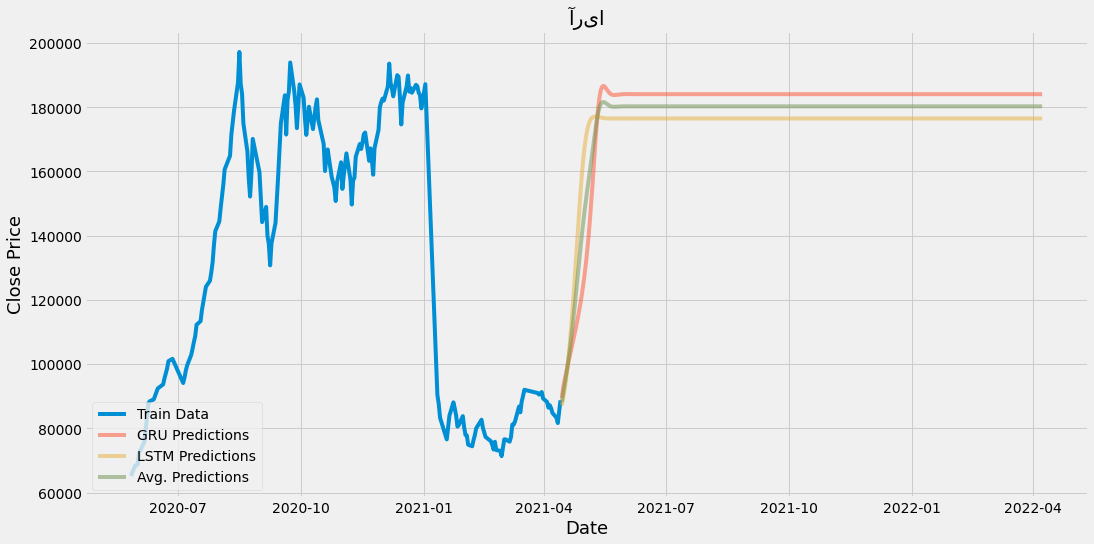

In [37]:
train = data

plt.figure(figsize=(16,8))
plt.title(ticker_name)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['close'])
plt.plot(new_data_GRU['Predictions'],alpha=0.5)
plt.plot(new_data_LSTM['Predictions'],alpha=0.5)
plt.plot((new_data_GRU['Predictions'] + new_data_LSTM['Predictions']) / 2,alpha=0.5)
plt.legend(['Train Data', 'GRU Predictions', 'LSTM Predictions', 'Avg. Predictions'], loc='lower left')
plt.show()


## Save Prediction Results 

In [38]:
if(path.exists('./prediction_output/')):
    print('Path already exists!')
else:
    mkdir('./prediction_output/')

Path already exists!


In [39]:

output_name = "./prediction_output/output_gru_" + ticker_name + ".csv"
new_data_GRU.to_csv(output_name)

output_name = "./prediction_output/output_lstm_" + ticker_name + ".csv"
new_data_LSTM.to_csv(output_name)

# GRU Prediction For The Next Day

## The Next Day's Close Price

In [40]:
tomorrows_close_price = predictionsGRU[0]
tomorrows_close_price

89508.28540199995

## Today's Close Price

In [41]:
todays_close_price = data.values[-1][0]
todays_close_price

88712.0

## Price Change

In [42]:
price_change = tomorrows_close_price - todays_close_price
price_change

796.2854019999504

## Price Change Percentage (%)

In [43]:
price_change_percentage = price_change / todays_close_price * 100
price_change_percentage

0.8976073158084029

## Trend Type

- 1 : Positive

- 0 : Neutral

- -1 : Negative

In [44]:
if(price_change == 0):
    trend = 0
else:
    trend = price_change / (np.abs(price_change))
trend

1.0

# LSTM Prediction For The Next Day

## The Next Day's Close Price

In [45]:
tomorrows_close_price = predictionsLSTM[0]
tomorrows_close_price

87116.58034729958

## Today's Close Price

In [46]:
todays_close_price = data.values[-1][0]
todays_close_price

88712.0

## Price Change

In [47]:
price_change = tomorrows_close_price - todays_close_price
price_change

-1595.4196527004242

## Price Change Percentage (%)

In [48]:
price_change_percentage = price_change / todays_close_price * 100
price_change_percentage

-1.7984259769821715

## Trend Type

- 1 : Positive

- 0 : Neutral

- -1 : Negative

In [49]:
if(price_change == 0):
    trend = 0
else:
    trend = price_change / (np.abs(price_change))
trend

-1.0

# Average of Predictions for The Next Day 

## Tomorrow's Close Price

In [50]:
tomorrows_close_price = (predictionsGRU[0] + predictionsLSTM[0]) / 2
tomorrows_close_price

88312.43287464976

## Today's Close Price

In [51]:
todays_close_price = data.values[-1][0]
todays_close_price

88712.0

## Price Change

In [52]:
price_change = tomorrows_close_price - todays_close_price
price_change

-399.5671253502369

## Price Change percentage (%)

In [53]:
price_change_percentage = price_change / todays_close_price * 100
price_change_percentage

-0.45040933058688437

## Trend Type

- 1 : Positive

- 0 : Neutral

- -1 : Negative

In [54]:
if(price_change == 0):
    trend = 0
else:
    trend = price_change / (np.abs(price_change))
trend

-1.0